In [209]:
import keras
import numpy as np
import os
import PIL
from keras.preprocessing.image import ImageDataGenerator
from pylab import imread, imshow
from skimage.color import rgb2gray
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

In [73]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        # second layer
        x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
        padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    return x

In [ ]:
def get_unet(dropout, input_img):
    inputs = input_img
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(inputs)
    conv1 = Dropout(dropout)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool1)
    conv2 = Dropout(dropout)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    #
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool2)
    conv3 = Dropout(dropout)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv3)

    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = concatenate([conv2,up1],axis=1)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(up1)
    conv4 = Dropout(dropout)(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv4)
    #
    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([conv1,up2], axis=1)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(up2)
    conv5 = Dropout(dropout)(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv5)
    #
    conv6 = Conv2D(2, (1, 1), activation='relu',padding='same',data_format='channels_first')(conv5)
    conv6 = core.Reshape((2,patch_height*patch_width))(conv6)
    conv6 = core.Permute((2,1))(conv6)
    ############
    conv7 = core.Activation('softmax')(conv6)

    model = Model(inputs=inputs, outputs=conv7)
    return model

In [267]:
def load_images_from_folder(folder_path):
    file_names = os.listdir(folder_path)
    file_names.sort()
    images = []
    for filename in file_names:
        try:
            image =imread(folder_path + filename)
            images.append(rgb2gray(image).reshape(32,32,1))
        except:
            continue
            
    return images

In [340]:
def train():
    X_train = np.array(load_images_from_folder("../../data/DRIVE/training/patches/"))
    y_train = np.array(load_images_from_folder("../../data/DRIVE/training/patchLabels/"))
    input_img = Input((32,32,1))
    model = get_unet(n_filters = 16, dropout = 0.05, input_img = input_img)
    opt  = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer = opt, loss = 'binary_crossentropy')
    model.summary()
    aug = ImageDataGenerator(horizontal_flip = True)
    
    res = model.fit_generator(aug.flow(X_train, y_train, batch_size = 100),
                              epochs = 5, steps_per_epoch = 191 )
    return model
    

In [341]:
res = train()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_636 (Conv2D)             (None, 32, 32, 16)   160         input_42[0][0]                   
__________________________________________________________________________________________________
batch_normalization_605 (BatchN (None, 32, 32, 16)   64          conv2d_636[0][0]                 
__________________________________________________________________________________________________
activation_605 (Activation)     (None, 32, 32, 16)   0           batch_normalization_605[0][0]    
__________________________________________________________________________________________________
conv2d_637

Epoch 1/5
191/191 [==============================] - 171s 896ms/step - loss: 0.6938
Epoch 2/5
191/191 [==============================] - 157s 823ms/step - loss: 0.5665
Epoch 3/5
191/191 [==============================] - 158s 826ms/step - loss: 0.5318
Epoch 4/5
191/191 [==============================] - 156s 815ms/step - loss: 0.5068
Epoch 5/5
191/191 [==============================] - 164s 860ms/step - loss: 0.4895


In [294]:
X_train = np.array(load_images_from_folder("../../data/DRIVE/training/patches/"))


0.97200817

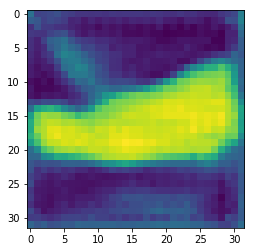

In [380]:
image_nr = 666
predict = res.predict(X_train[image_nr:(image_nr+1)])
#predict[predict > 0.5] = 1
#predict[predict <= 0.5] = 0
imshow(predict.reshape((32,32)))


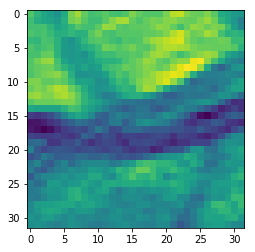

In [381]:
imshow(X_train[image_nr].reshape((32,32)))

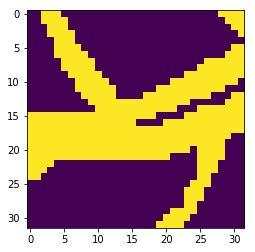

In [382]:
y_train = np.array(load_images_from_folder("../../data/DRIVE/training/patchLabels/"))
imshow(y_train[image_nr].reshape(32,32))